In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
import random

In [3]:
def run():
    env = gym.make('MountainCar-v0')
    state, _ = env.reset()
    terminated = False

    rewards = 0

    while not terminated and rewards > -1000:
        action = env.action_space.sample()

        new_state, reward, terminated, _, _ = env.step(action)

        state = new_state
        rewards += reward
    env.close()

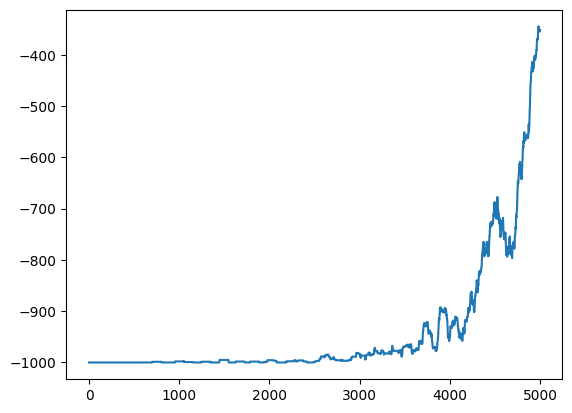

In [11]:

def run_linear_obs():
    env = gym.make('MountainCar-v0')
    
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)

    episodes = 5000
    learning_rate_a = 0.9
    discount_factor_g = 0.9
    q = np.zeros((len(pos_space), len(vel_space), env.action_space.n)) # init 20x20x3 array

    epsilon = 1
    epsilon_decay_rate = epsilon/episodes
    rng = np.random.default_rng()
    rewards_per_episode = np.zeros(episodes)
    
    for i in range(episodes):
        state, _ = env.reset()
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        terminated = False
    
        rewards = 0
    
        while not terminated and rewards > -1000:
            if rng.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v,:])
                
    
            new_state, reward, terminated, _, _ = env.step(action)
    
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)

            q[state_p, state_v, action] = (
                q[state_p, state_v, action] +
                learning_rate_a *
                (
                    reward +
                    discount_factor_g *
                    np.max(q[new_state_p, new_state_v,:]) -
                    q[state_p, state_v, action]
                )
            )
            
            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            rewards += reward
        epsilon = max(epsilon - epsilon_decay_rate, 0)
        rewards_per_episode[i] = rewards
            
    env.close()
    mean_rewards = np.zeros(episodes)
    for t in range(episodes):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):t+1])
    plt.plot(mean_rewards)

run_linear_obs()

In [12]:
## now we are going to use deep q learning

class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.out = nn.Linear(h1_nodes, out_actions)

    def forward(self, x):
        return self.out(F.relu(self.fc1(x)))

class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)


In [31]:
class MountainCarDQL():
    learning_rate_a = 0.001
    discount_factor_g = 0.9
    network_sync_rate = 50000
    replay_memory_size = 100000
    mini_batch_size = 32

    loss_fn = nn.MSELoss()
    optimizer = None

    def state_to_dqn_input(self, state, num_states)-> torch.Tensor: ## one hot encoding
        input_tensor = torch.zeros(num_states)
        input_tensor[state] = 1
        return input_tensor
    
    def train(self, episodes):
        env = gym.make('MountainCar-v0')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        epsilon = 1
        memory = ReplayMemory(self.replay_memory_size)

        policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)

        target_dqn.load_state_dict(policy_dqn.state_dict())

        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        rewards_per_episode = np.zeros(episodes)

        epsilon_history = []
        rng = np.random.default_rng()
        step_count = 0

        for i in range(episodes):
            state, _ = env.reset()
            terminated = False

            rewards = 0
            while not terminated and rewards > -1000:
                if rng.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state, num_states)).argmax().item()
                new_state, reward, terminated, truncated, _ = env.step(action)
                memory.append((state, action, new_state, reward, terminated))
                                         
                state = new_state
                step_count+=1
                rewards += reward
            rewards_per_episode[i] = rewards

            if len(memory) >self.mini_batch_size:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0
        env.close()
        plt.figure(1)
        mean_rewards = np.zeros(episodes)
        for t in range(episodes):
            mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):t+1])

        plt.subplot(121)
        plt.plot(mean_rewards)

        plt.subplot(122)
        plt.plot(epsilon_history)

    def optimize(self, mini_batch, policy_dqn, target_dqn):
        num_states = policy_dqn.fc1.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state, num_states)).max()
                    )
            current_q = policy_dqn(self.state_to_dqn_input(state, num_states))
            current_q_list.append(current_q)

            target_q = target_dqn(self.state_to_dqn_input(state, num_states))
            target_q[action] = target

            target_q_list.append(target_q)

        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
mountain_car = MountainCarDQL()
mountain_car.train(10000)